<h3>Introduction</h3>

<h5>Background</h5>
Gaming has become a significant part of many people’s lives, experiencing tremendous growth over the past decade. At the University of British Columbia, a research project has been established to explore how video game data can advance artificial intelligence. Professor Frank Wood founded the Pacific Laboratory for Artificial Intelligence also known as (PLAI) which is a research project using data collected from a Minecraft server to understand how people play video games. Their goal is to analyze how players interact with the game seeking insight to optimize recruiting efforts and resource allocation. PLAI looks to use this data to advance artificial intelligence through generative modeling, reinforcement learning, probabilistic programming and Bayesian inference to develop a safe and reliable AI.

<h5>Question</h5>
How well can we predict whether a player subscribes to a game-related newsletter based on their age and playtime (played hours)?

<h5>Data Description</h5>
For this data analysis we used the player.csv dataset which records user data from a Minecraft server. It contains 195 observations and 7 variables that details a user's profile and activity. The dataset contains categorical variables such as experience which consists of 5 different classes, Pro, Veteran, Amateur, Beginner and Regular and Gender which is split into , male, female, Agender, non binary, two-spirited, other and prefer not to say. A boolean variable subscribed indicates whether a user is subscribed or not. Numerical variables include played hours and age. String variables include name and hashed email which stores the user's email anonymously.



<h3>Methods and Results</h3>

<h5>Loading Packages</h5>
First we imported the package tidyverse and any other packages we needed for the predictive model into Jupyter.  


In [1]:
install.packages("tidyverse")
library(ggplot2)
library(tidyverse)
library(tidymodels)
library(gridExtra)
install.packages("kknn")
options(repr.matrix.max.rows=10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ─

<h5>Loading, Wrangling and Cleaning the Data</h5>

We loaded the player data from a GitHub raw URL using "read_csv". We used the mutate function in R to convert the data set’s column played hours and age as numeric and subscribe as a factor. Then we used drop_na to remove any NA valued observations. 



In [19]:
url <- "https://raw.githubusercontent.com/Liam-ma06/DSCI_Project_final_report/refs/heads/main/players.csv"

player <- read_csv(url, show_col_types=FALSE) |>
    mutate(Age=as.numeric(Age))|>
    mutate(played_hours=as.numeric(played_hours))|>
    mutate(subscribe=as_factor(subscribe))|>
    drop_na(Age, played_hours, subscribe)


<h5>Data Set Proportions</h5>

We used "group_by" and "summarize" to find the percentages of subscribed and unsubscribed in the player.csv dataset. We will do this again to see if our proportions are preserved when we split the data.


In [18]:
player_proportions <- player|>
    group_by(subscribe)|>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(player))
player_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


<h5>Dataset Graph</h5>

The code creates a scatter plot with "ggplot" that visualizes the relationship between Age and played_hours, with points colored based on the subscribe status. The "geom_point" function adds the data points to the plot, and "alpha=0.5" makes the points semi-transparent to improve readability. The "labs" function sets the axis labels and legend title. "scale_color_manual" customizes the colors of the points for the two subscription categories (darkorange for one group and steelblue for the other). Finally, "theme(text = element_text(size = 12))" adjusts the font size of the text elements in the plot.

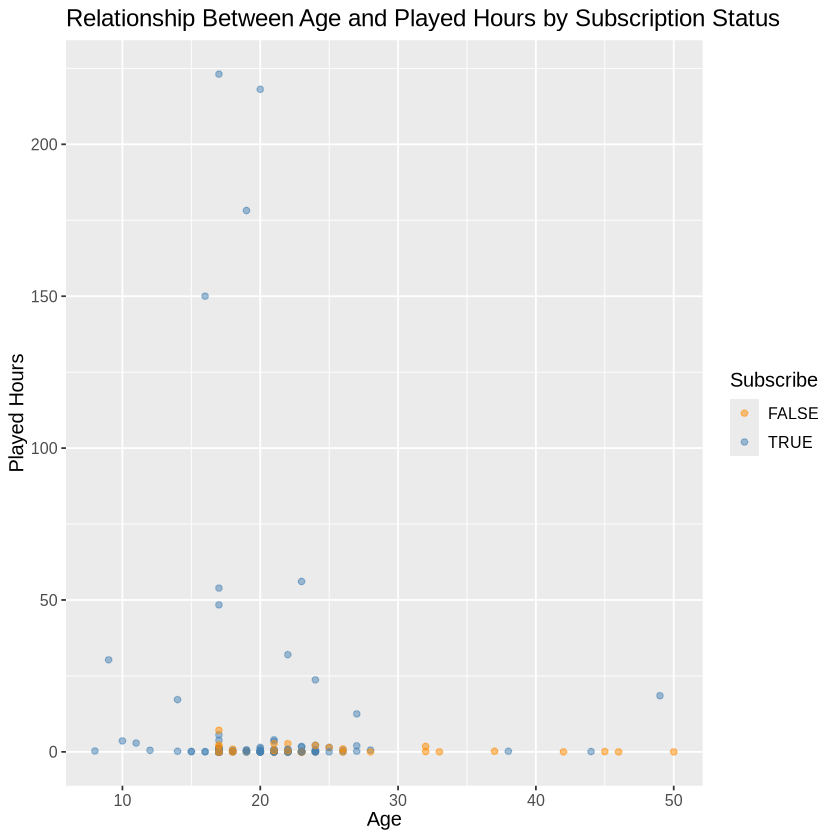

In [22]:
player_graph <- player|>
    ggplot(aes(x=Age, y=played_hours, color=subscribe))+
    geom_point(alpha=0.5)+
    labs(x="Age", y="Played Hours", color="Subscribe", title="Relationship Between Age and Played Hours by Subscription Status")+
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 12))
player_graph
    

This graph suggests a trend where users with higher played hours are more likely to be subscribed, as most of the points representing high playtime are associated with subscribers. Additionally younger players are more likely to subscribe than older players. 

<h5>Splitting Data</h5>

We split the dataset into training and testing sets using the "initial_split" function. It sets the proportion of data used for training to 75% (prop=0.75) and ensures that the split is stratified by the subscribe variable, meaning the proportion of subscribed and non-subscribed users is maintained in both the training and testing sets (strata=subscribe). After splitting, the "training" is used to extract the training set, and the "testing" extracts the testing set. This ensures that the model will be trained on a representative subset of the data and tested on a separate subset to evaluate its performance.

In [4]:
player_split <- initial_split(player, prop=0.75, strata=subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

<h5>Data Set Proportions</h5>

We used "group_by" and "summarize" to find the percentages of subscribed and unsubscribed in the player training dataset. As seen the proportions are preserved when we split the data with 73% being subscribed and 26% not being subscribed.

In [5]:
player_proportions1 <- player_train|>
    group_by(subscribe)|>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(player_train))
player_proportions1
    

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


<h5>Tuning and Evaluating Knn Model</h5>

For predictive modelling for subscription for players, we decided to use k-Nearest Neighbors (knn) classification algorithm. We chose to use it because its simple yet effective for prediction categroical outcomes such as whether a player subscribes to the game-related newsletter. Knn classification categorizes data points based on the majority class of their nearest neighbors. Therfore to optimize the models performance we need to find the optimal k value. 

We first set a random seed for reproducibility. Then using our training data we use the "recipe" framework to stadardize our scaling and centering all our predictors. We then use "nearest_neighbor" creating a Knn model with the number of neighbors set to be tuned. To safeguard against overfitting and ensure balanced groups in each fold we implemented a 5 fold cross validation on the training set. This method divides the data into five subsets enabling a comprehensive evaluation of the model's performance across different subsets. Finally a workflow is created that combines the recipe and model, and the "tune_grid" function tests different values for the number of neighbors, from 1 to 50, using the cross-validation splits. The performance metrics for each tested combination are collected, allowing for the evaluation of the best model configuration.

In [6]:
set.seed(123)

player_recipe <- recipe(subscribe ~ Age + played_hours, data=player_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")

player_vfold <- vfold_cv(player_train, v=5, strata=subscribe)

knn_results <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(knn_tune)|>
    tune_grid(resamples = player_vfold, grid=tibble(neighbors=seq(from=1, to=50, by=2)))|>
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4204598,5,0.04695286,Preprocessor1_Model01
1,roc_auc,binary,0.4329545,5,0.05568129,Preprocessor1_Model01
3,accuracy,binary,0.4770608,5,0.04356948,Preprocessor1_Model02
3,roc_auc,binary,0.5214711,5,0.02809583,Preprocessor1_Model02
5,accuracy,binary,0.5729392,5,0.03385628,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,roc_auc,binary,0.6255141,5,0.036243911,Preprocessor1_Model23
47,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model24
47,roc_auc,binary,0.6337044,5,0.049077954,Preprocessor1_Model24


<h5>Model Evaluation</h5>

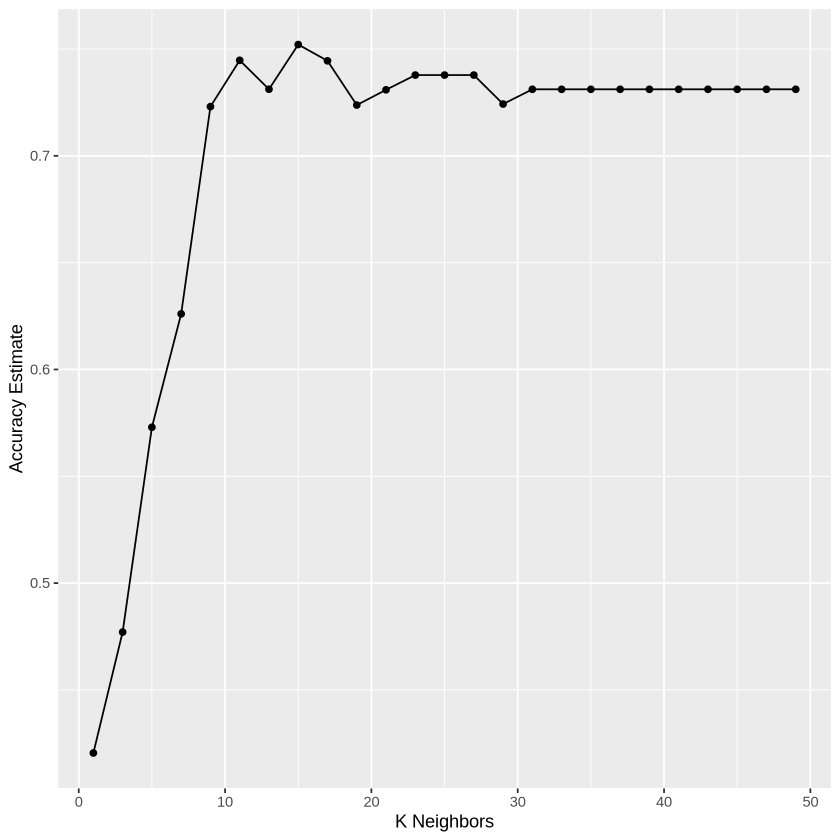

In [7]:
accuracies <- knn_results |>
    filter(.metric=="accuracy")|>
    mutate(mean=as.numeric(mean), neighbors=as.numeric(neighbors))

K_accuracy_plot <- accuracies |>
    ggplot(aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x="K Neighbors", y="Accuracy Estimate")
K_accuracy_plot

In [9]:
best_accuracy <- accuracies |>
  filter(mean == max(mean))
best_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7521018,5,0.02207079,Preprocessor1_Model08


In [12]:

set.seed(1234)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
  set_engine("kknn") |>
  set_mode("classification")

# 2. Create the workflow
knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  fit(data = player_train)


player_predictions <- knn_fit |>
  predict(player_test) |>
  bind_cols(player_test)


player_accuracy <- player_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()


player_accuracy

[1] 0.755102

In [14]:
confusion_matrix <- player_predictions|>
    conf_mat(truth=subscribe, estimate=.pred_class)
confusion_matrix

          Truth
Prediction FALSE TRUE
     FALSE     1    0
     TRUE     12   36